# NB-AK5: Long-term annual total fluxes changes for early, mid and late 21st century periods from historical period

This notebook is similar to NB-AK4, but use actual change in flux in future, relative to historical period

## module loading...

In [1]:
%matplotlib inline  
import os
import sys
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from timeit import default_timer as timer

print("\nThe Python version: %s.%s.%s" % sys.version_info[:3])
print(xr.__name__, xr.__version__)

mpl.rcParams['xtick.labelsize']='small'


The Python version: 3.7.0
xarray 0.16.2


In [2]:
from cmip5_oconus import print_date
print_date()

from cmip5_oconus.data_catalog import load_monthly_historical_hydro_datasets, resample_data
from cmip5_oconus.data_catalog import load_monthly_cmip5_hydro_datasets
from cmip5_oconus.plot import custom_div_cmap, MidpointNormalize, add_ylabel
from cmip5_oconus.utils import calc_change

Last executed: 2022-04-25 09:23:55.170711 by mizukami on crhtc36


In [3]:
#from dask_jobqueue import PBSCluster
#cluster = PBSCluster(processes=9, threads=4, memory="108GB",
#                  walltime='00:40:00')
#cluster.scale(jobs=3)

#from dask_jobqueue import SLURMCluster
#cluster = SLURMCluster()
#cluster.scale(jobs=5)

In [4]:
#from dask.distributed import Client
#client = Client(cluster)

In [5]:
#client

-------------------------
## Setup 

In [3]:
figSave = True

In [4]:
gcms            = ["ACCESS1-3","CanESM2","CCSM4","CSIRO-Mk3-6-0","GFDL-ESM2M","HadGEM2-ES","inmcm4","MIROC5","MPI-ESM-MR","MRI-CGCM3"]
hydro_flux_vars = ['PRCP', 'EVAP', 'total_runoff']
period_hist     = slice('1970-01-01', '1999-12-31')
period_futr     = {'early' : slice('2010-01-01', '2039-12-31'),
                   'middle': slice('2040-01-01', '2069-12-31'),
                   'late'  : slice('2070-01-01', '2099-12-31')}

## Load the data

In [5]:
xr.set_options(file_cache_maxsize=12000)
histo_data = load_monthly_historical_hydro_datasets(models=gcms, variables=hydro_flux_vars, region='AK', parallel=False)
rcp45_data = load_monthly_cmip5_hydro_datasets(scen='rcp45', models=gcms, variables=hydro_flux_vars, region='AK', parallel=False)
rcp85_data = load_monthly_cmip5_hydro_datasets(scen='rcp85', models=gcms, variables=hydro_flux_vars, region='AK', parallel=False)

load_monthly_historical_hydro_datasets
load_monthly_cmip5_hydro_datasets
load_cmip5_dataset


100%|██████████| 10/10 [00:22<00:00,  2.26s/it]

load_obs_dataset


load_monthly_cmip5_hydro_datasets
load_cmip5_dataset


100%|██████████| 10/10 [00:47<00:00,  4.79s/it]

load_monthly_cmip5_hydro_datasets
load_cmip5_dataset



100%|██████████| 10/10 [00:50<00:00,  5.04s/it]


## Compute 30-yr annual mean for 4 periods - historical, early, mid and late

In [6]:
histo_hydro_means = resample_data(histo_data['gcm'].sel(time=period_hist), region='AK', freq='AS').persist().mean('time')

rcp45_hydro_means = {}
rcp85_hydro_means = {}
for key, futr_period in period_futr.items():
    rcp45_hydro_means[key] = resample_data(rcp45_data.sel(time=futr_period), region='AK', freq='AS').persist().mean('time')
    rcp85_hydro_means[key] = resample_data(rcp85_data.sel(time=futr_period), region='AK', freq='AS').persist().mean('time')

## Compute 30-yr annual runoff ratio and  Evaporation ratio

In [7]:
%%time
histo_hydro_means['EVAP_RATIO'] = histo_hydro_means['EVAP']/histo_hydro_means['PRCP']
histo_hydro_means['RO_RATIO']   = histo_hydro_means['total_runoff']/histo_hydro_means['PRCP']
for key, futr_period in period_futr.items():
    rcp45_hydro_means[key]['EVAP_RATIO'] = rcp45_hydro_means[key]['EVAP']/rcp45_hydro_means[key]['PRCP']
    rcp85_hydro_means[key]['EVAP_RATIO'] = rcp85_hydro_means[key]['EVAP']/rcp85_hydro_means[key]['PRCP']
    rcp45_hydro_means[key]['RO_RATIO'] = rcp45_hydro_means[key]['total_runoff']/rcp45_hydro_means[key]['PRCP']
    rcp85_hydro_means[key]['RO_RATIO'] = rcp85_hydro_means[key]['total_runoff']/rcp85_hydro_means[key]['PRCP']    

## Compute difference in 30-yr annual mean between historical and future

In [8]:
rcp45_hydro_30yr_diff = {}
rcp85_hydro_30yr_diff = {}
diff_rcp_hydro_30yr_change ={}
for key, futr_period in period_futr.items():
    rcp45_hydro_30yr_diff[key] = calc_change(histo_hydro_means, rcp45_hydro_means[key], pct=False).persist()
    rcp85_hydro_30yr_diff[key] = calc_change(histo_hydro_means, rcp85_hydro_means[key], pct=False).persist()
    
    diff_rcp_hydro_30yr_change[key] =rcp85_hydro_30yr_diff[key] - rcp45_hydro_30yr_diff[key]

/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x

## Plotting

In [9]:
# create colormap
# ---------------

from matplotlib.colors import LinearSegmentedColormap

# create a colormap that consists of
# - 1/5 : custom colormap, ranging from white to the first color of the colormap
# - 4/5 : existing colormap

# set upper part: 4 * 256/4 entries
upper = mpl.cm.Spectral_r(np.arange(256)) # mpl.cm.YlGnBu(np.arange(256)), mpl.cm.Spectral(np.arange(256))
# set lower part: 1 * 256/4 entries
# - initialize all entries to 1 to make sure that the alpha channel (4th column) is 1
lower = np.ones((int(256/4),4))
# - modify the first three columns (RGB):
#   range linearly between white (1,1,1) and the first color of the upper colormap
for i in range(3):
    lower[:,i] = np.linspace(0.9, upper[0,i], lower.shape[0])

# combine parts of colormap
cmap = np.vstack(( lower, upper ))

# convert to matplotlib colormap
cmap = mpl.colors.ListedColormap(cmap, name='myColorMap', N=cmap.shape[0])
cmap.set_under('xkcd:light grey')

# option 2
cmap1 = LinearSegmentedColormap.from_list('custom1', 
                                          [(0.00, 'xkcd:very light green'),
                                           (0.20, 'xkcd:light blue'),
                                           (0.50, 'xkcd:lightish blue'),
                                           (0.70, 'xkcd:blue'),
                                           (1.00, 'xkcd:purple')], N=256)
cmap1.set_over('xkcd:dark purple')
cmap1.set_under('xkcd:light grey')


cmap_change_PR = LinearSegmentedColormap.from_list('custom blue', 
                                             [(0,    'xkcd:red'),
                                              (0.20, 'xkcd:light grey'),
                                              (1,    'xkcd:blue')], N=256)

cmap_change_ET = LinearSegmentedColormap.from_list('custom blue', 
                                             [(0,    'xkcd:red'),
                                              (0.35, 'xkcd:light grey'),
                                              (1,    'xkcd:blue')], N=256)

------------
 - Change in 30yr mean annual total fluxes between historical and three future periods in 21st century (early, mid, and late) 

/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mizuka

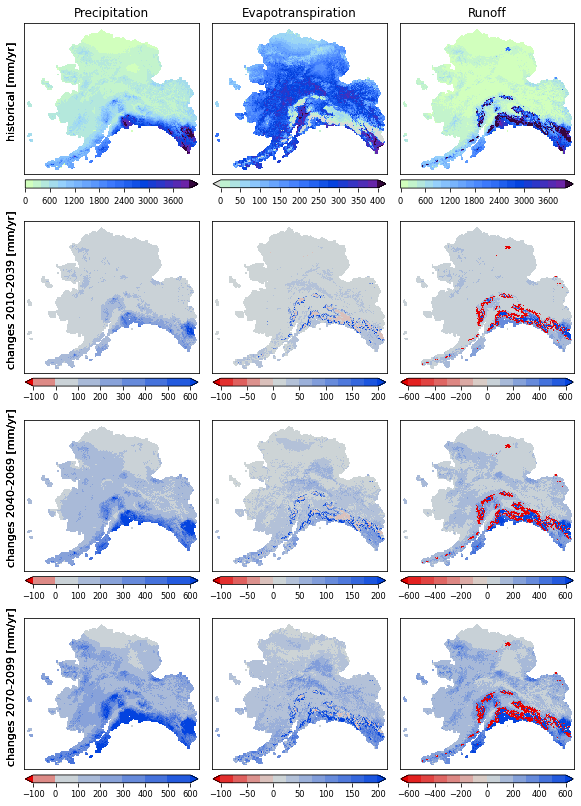

In [35]:
cm = {'history'   : cmap1,
      'change_PR' : cmap_change_PR,
      'change_ET' : cmap_change_ET,
      'change_RO' : custom_div_cmap(numcolors=256, mincol='xkcd:red', midcol='xkcd:light grey', maxcol='xkcd:blue')}

sfmt = mpl.ticker.ScalarFormatter(useMathText=True)
#sfmt.set_powerlimits((0, 0))

cbar_kwrgs = {'mean':   {"orientation":"horizontal", "shrink":0.990, "pad":0.03, 'format':sfmt},
              'change': {"orientation":"horizontal", "shrink":0.990, "pad":0.03}}

style_kwargs = {'mean':   {'add_labels': False, 'xticks':[], 'yticks':[], 'cbar_kwargs': cbar_kwrgs['mean']},
                'change': {'add_labels': False, 'xticks':[], 'yticks':[], 'cbar_kwargs': cbar_kwrgs['change']}
               }

kwargs = {'change-PRCP':         {'levels': 8,  'vmin':-100, 'vmax':600, 'cmap':cm['change_PR'],    'extend':'both',  **style_kwargs['change']},
          'change-EVAP':         {'levels': 13, 'vmin':-100, 'vmax':200, 'cmap':cm['change_ET'],    'extend':'both', **style_kwargs['change']},
          'change-total_runoff': {'levels': 13, 'vmin':-600, 'vmax':600, 'cmap':cm['change_RO'], 'extend':'both',  **style_kwargs['change']},
          'PRCP':                {'levels': 21, 'vmin':0, 'vmax':4000, 'cmap':cm['history'], 'extend':'max',  **style_kwargs['mean']},
          'EVAP':                {'levels': 17, 'vmin':0, 'vmax':400,  'cmap':cm['history'], 'extend':'both', **style_kwargs['mean']},
          'total_runoff':        {'levels': 21, 'vmin':0, 'vmax':4000, 'cmap':cm['history'], 'extend':'max',  **style_kwargs['mean']}}

var_title = {'PRCP':'Precipitation', 'EVAP':'Evapotranspiration', 'total_runoff':'Runoff'}

fig, axes = plt.subplots(nrows=4, ncols=3, sharex=True, sharey=True, figsize=(8.125,11.25))
plt.subplots_adjust(left=0.045, bottom=0.0125, right=0.985, top=0.975, hspace=0.075, wspace=0.075)

for col, var in enumerate(['PRCP','EVAP','total_runoff']):
    histo_hydro_means.mean(dim='gcm')[var].plot.pcolormesh(ax=axes[0, col], **kwargs[var])
    rcp85_hydro_30yr_diff['early'].mean(dim='gcm')[var].plot.pcolormesh(ax=axes[1, col],  **kwargs[f'change-{var}'])
    rcp85_hydro_30yr_diff['middle'].mean(dim='gcm')[var].plot.pcolormesh(ax=axes[2, col], **kwargs[f'change-{var}'])
    rcp85_hydro_30yr_diff['late'].mean(dim='gcm')[var].plot.pcolormesh(ax=axes[3, col],   **kwargs[f'change-{var}'])
    
    add_ylabel(axes[0, 0], 'historical [mm/yr]', fontsize=11)
    add_ylabel(axes[1, 0], 'changes 2010-2039 [mm/yr]', fontsize=11)
    add_ylabel(axes[2, 0], 'changes 2040-2069 [mm/yr]', fontsize=11)
    add_ylabel(axes[3, 0], 'changes 2070-2099 [mm/yr]', fontsize=11)
    axes[0, col].set_title(var_title[var], fontsize=12)
    
#plt.tight_layout()
if figSave:
    plt.savefig(f'NB-AK5_Fig1_annual_mean_change_rcp85.png', dpi=300)

------------
 - The same as above except for two future periods in 21st century (early, mid, and late) 

/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mizuka

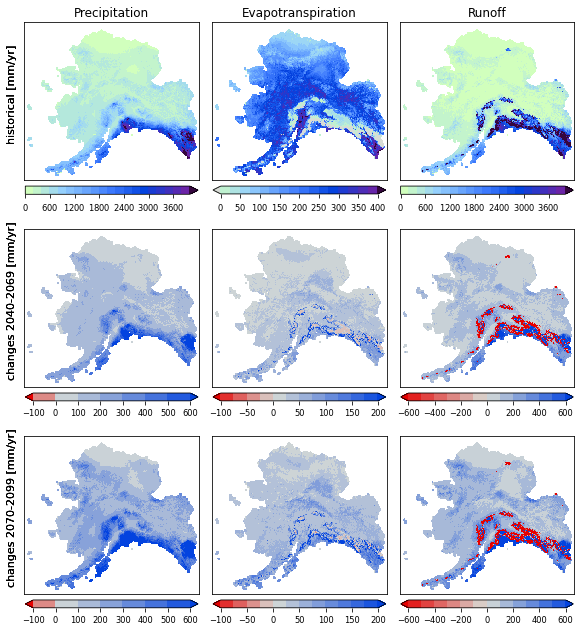

In [36]:
cm = {'history'   : cmap1,
      'change_PR' : cmap_change_PR,
      'change_ET' : cmap_change_ET,
      'change_RO' : custom_div_cmap(numcolors=256, mincol='xkcd:red', midcol='xkcd:light grey', maxcol='xkcd:blue')}

sfmt = mpl.ticker.ScalarFormatter(useMathText=True)
#sfmt.set_powerlimits((0, 0))

cbar_kwrgs = {'mean':   {"orientation":"horizontal", "shrink":0.990, "pad":0.03, 'format':sfmt},
              'change': {"orientation":"horizontal", "shrink":0.990, "pad":0.03}}

style_kwargs = {'mean':   {'add_labels': False, 'xticks':[], 'yticks':[], 'cbar_kwargs': cbar_kwrgs['mean']},
                'change': {'add_labels': False, 'xticks':[], 'yticks':[], 'cbar_kwargs': cbar_kwrgs['change']}
               }

kwargs = {'change-PRCP':         {'levels': 8,  'vmin':-100, 'vmax':600, 'cmap':cm['change_PR'],    'extend':'both',  **style_kwargs['change']},
          'change-EVAP':         {'levels': 13, 'vmin':-100, 'vmax':200, 'cmap':cm['change_ET'],    'extend':'both', **style_kwargs['change']},
          'change-total_runoff': {'levels': 13, 'vmin':-600, 'vmax':600, 'cmap':cm['change_RO'], 'extend':'both',  **style_kwargs['change']},
          'PRCP':                {'levels': 21, 'vmin':0, 'vmax':4000, 'cmap':cm['history'], 'extend':'max',  **style_kwargs['mean']},
          'EVAP':                {'levels': 17, 'vmin':0, 'vmax':400,  'cmap':cm['history'], 'extend':'both', **style_kwargs['mean']},
          'total_runoff':        {'levels': 21, 'vmin':0, 'vmax':4000, 'cmap':cm['history'], 'extend':'max',  **style_kwargs['mean']}}

var_title = {'PRCP':'Precipitation', 'EVAP':'Evapotranspiration', 'total_runoff':'Runoff'}

fig, axes = plt.subplots(nrows=3, ncols=3, sharex=True, sharey=True, figsize=(8.125,8.75))
plt.subplots_adjust(left=0.045, bottom=0.0125, right=0.985, top=0.975, hspace=0.075, wspace=0.075)

for col, var in enumerate(['PRCP','EVAP','total_runoff']):
    histo_hydro_means.mean(dim='gcm')[var].plot.pcolormesh(ax=axes[0, col], **kwargs[var])
    rcp85_hydro_30yr_diff['middle'].mean(dim='gcm')[var].plot.pcolormesh(ax=axes[1, col], **kwargs[f'change-{var}'])
    rcp85_hydro_30yr_diff['late'].mean(dim='gcm')[var].plot.pcolormesh(ax=axes[2, col],   **kwargs[f'change-{var}'])
    
    add_ylabel(axes[0, 0], 'historical [mm/yr]', fontsize=11)
    add_ylabel(axes[1, 0], 'changes 2040-2069 [mm/yr]', fontsize=11)
    add_ylabel(axes[2, 0], 'changes 2070-2099 [mm/yr]', fontsize=11)
    axes[0, col].set_title(var_title[var], fontsize=12)
    
if figSave:
    plt.savefig(f'NB-AK5_Fig2_annual_mean_change_mid_late_rcp85.png', dpi=300)

------------
 - Difference between two RCPs in change in 30yr mean annual total for late 21st century

/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


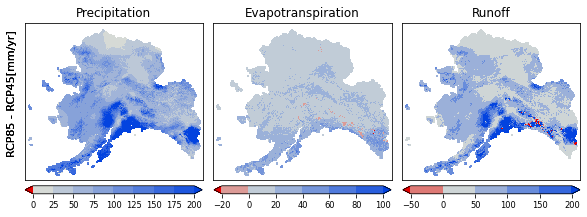

In [13]:
cmap_RCP_diff_PR = LinearSegmentedColormap.from_list('custom blue', 
                                                     [(0,    'xkcd:red'),
                                                      (0.10, 'xkcd:light grey'),
                                                      (1,    'xkcd:blue')], N=256)

cmap_RCP_diff_ET = LinearSegmentedColormap.from_list('custom blue', 
                                                    [(0,    'xkcd:red'),
                                                     (0.20, 'xkcd:light grey'),
                                                     (1,    'xkcd:blue')], N=256)

cmap_RCP_diff_RO = LinearSegmentedColormap.from_list('custom blue', 
                                                    [(0,    'xkcd:red'),
                                                     (0.30, 'xkcd:light grey'),
                                                     (1,    'xkcd:blue')], N=256)

style_kwargs = {'add_labels': False, 'xticks':[], 'yticks':[], 'cbar_kwargs': dict(orientation="horizontal", shrink=0.995, pad=0.03)}

kwargs = {'change-PRCP':         {'levels': 9,  'vmin': 0,  'vmax':200, 'cmap':cmap_RCP_diff_PR, 'extend':'both', **style_kwargs},
          'change-EVAP':         {'levels': 7,  'vmin':-20, 'vmax':100, 'cmap':cmap_RCP_diff_ET, 'extend':'both', **style_kwargs},
          'change-total_runoff': {'levels': 6,  'vmin':-50, 'vmax':200, 'cmap':cmap_RCP_diff_RO, 'extend':'both', **style_kwargs}}


var_title = {'PRCP':'Precipitation', 'EVAP':'Evapotranspiration', 'total_runoff':'Runoff'}

fig, axes = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=True, figsize=(8.125,3))
plt.subplots_adjust(left=0.040, bottom=0.0125, right=0.990, top=0.900, hspace=0.060, wspace=0.060)

for col, var in enumerate(['PRCP','EVAP','total_runoff']):
    diff_rcp_hydro_30yr_change['late'].mean(dim='gcm')[var].plot.pcolormesh(ax=axes[col], **kwargs[f'change-{var}'])
    
    add_ylabel(axes[0], 'RCP85 - RCP45[mm/yr]', fontsize=11)
    axes[col].set_title(var_title[var], fontsize=12)
    
if figSave:
    plt.savefig(f'NB-AK5_Fig3_annual_mean_change_late_diff_rcp.png', dpi=300)

## Runnoff ratio and evaporation ratio - historical ensemble mean and changes

/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade

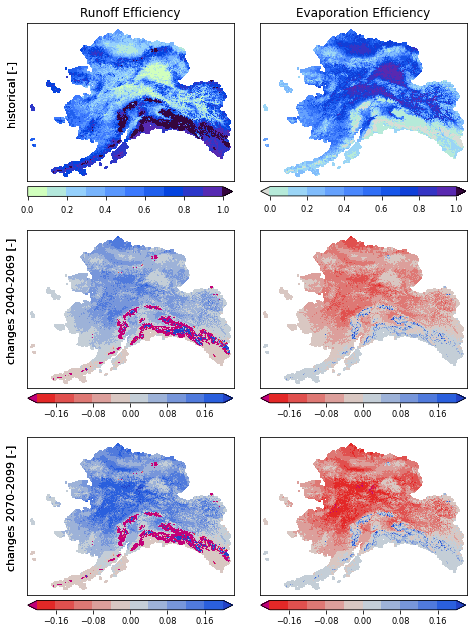

In [21]:
cmap_change_ratio = custom_div_cmap(numcolors=255, mincol='xkcd:red', midcol='xkcd:light grey', maxcol='xkcd:blue')
cmap_change_ratio.set_over('xkcd:blue blue')
cmap_change_ratio.set_under('xkcd:magenta')

cm = {'history'   : cmap1,
      'change_er' : cmap_change_ratio,
      'change_rr' : cmap_change_ratio}

sfmt = mpl.ticker.ScalarFormatter(useMathText=True)
sfmt.set_powerlimits((-5, 5))

cbar_kwrgs = {'mean':   {"orientation":"horizontal", "shrink":0.990, "pad":0.03, 'format':sfmt},
              'change': {"orientation":"horizontal", "shrink":0.990, "pad":0.03}}

style_kwargs = {'mean':   {'add_labels': False, 'xticks':[], 'yticks':[], 'cbar_kwargs': cbar_kwrgs['mean']},
                'change': {'add_labels': False, 'xticks':[], 'yticks':[], 'cbar_kwargs': cbar_kwrgs['change']}
               }

kwargs = {'change-EVAP_RATIO': {'levels': 11, 'vmin':-0.2, 'vmax':0.2, 'cmap':cm['change_er'], 'extend':'both',    **style_kwargs['change']},
          'change-RO_RATIO':   {'levels': 11, 'vmin':-0.2, 'vmax':0.2, 'cmap':cm['change_rr'], 'extend':'both',    **style_kwargs['change']},
          'EVAP_RATIO':        {'levels': 11, 'vmin':0.0, 'vmax':1.0,  'cmap':cm['history'],   'extend':'both',    **style_kwargs['mean']}, #'levels': 46, 
          'RO_RATIO':          {'levels': 11, 'vmin':0.0, 'vmax':1.0,  'cmap':cm['history'],   'extend':'max', **style_kwargs['mean']}} #'levels': 11, 

var_title = {'EVAP_RATIO':'Evaporation Efficiency', 'RO_RATIO':'Runoff Efficiency'}

fig, axes = plt.subplots(nrows=3, ncols=2, sharex=True, sharey=True, figsize=(6.50,8.75))
plt.subplots_adjust(left=0.045, bottom=0.0125, right=0.985, top=0.975, hspace=0.075, wspace=0.125)

for col, var in enumerate(['RO_RATIO','EVAP_RATIO']):
    histo_hydro_means.mean(dim='gcm')[var].plot.pcolormesh(ax=axes[0, col], **kwargs[var])
    rcp85_hydro_30yr_diff['middle'].mean(dim='gcm')[var].plot.pcolormesh(ax=axes[1, col], **kwargs[f'change-{var}'])
    rcp85_hydro_30yr_diff['late'].mean(dim='gcm')[var].plot.pcolormesh(ax=axes[2, col],   **kwargs[f'change-{var}'])
    
    add_ylabel(axes[0, 0], 'historical [-]', fontsize=11)
    add_ylabel(axes[1, 0], 'changes 2040-2069 [-]', fontsize=11)
    add_ylabel(axes[2, 0], 'changes 2070-2099 [-]', fontsize=11)
    axes[0, col].set_title(var_title[var], fontsize=12)
if figSave:
    plt.savefig(f'NB-AK5_Fig14_annual_mean_ratio_change_mid_late_rcp85.png', dpi=300)

### alternative plots for ratio

In [61]:
cmap_ratio = LinearSegmentedColormap.from_list('custom blue', 
                                       [(0,    'xkcd:red'),
                                        (0.05, 'xkcd:light grey'),
                                        (1,    'xkcd:blue')], N=256)

cmap_change_ratio = LinearSegmentedColormap.from_list('custom blue', 
                                                   [(0,    'xkcd:red'),
                                                    (0.50, 'xkcd:light grey'),
                                                    (1,    'xkcd:blue')], N=256)

style_kwargs = {'add_labels': False, 'xticks':[], 'yticks':[], 'cbar_kwargs': dict(orientation="horizontal", shrink=0.995, pad=0.03)}

kwargs = {'ratio':         {'levels': 11,  'vmin': 0,  'vmax':1, 'cmap':cmap_ratio, 'extend':'both', **style_kwargs},
          'change-ratio':  {'levels': 5,  'vmin':-0.2, 'vmax':0.2, 'cmap':cmap_change_ratio, 'extend':'both', **style_kwargs}}

### runoff ratio

/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


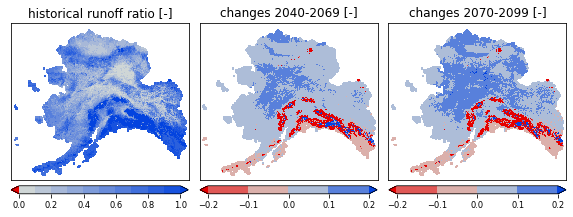

In [62]:
fig, axes = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=True, figsize=(8.125,3))
plt.subplots_adjust(left=0.040, bottom=0.0125, right=0.990, top=0.900, hspace=0.060, wspace=0.060)
histo_hydro_means.mean(dim='gcm')['RO_RATIO'].plot.pcolormesh(ax=axes[0], **kwargs['ratio'])
rcp85_hydro_30yr_diff['middle'].mean(dim='gcm')['RO_RATIO'].plot.pcolormesh(ax=axes[1], **kwargs[f'change-ratio'])
rcp85_hydro_30yr_diff['late'].mean(dim='gcm')['RO_RATIO'].plot.pcolormesh(ax=axes[2],   **kwargs[f'change-ratio'])
    
axes[0].set_title('historical runoff ratio [-]', fontsize=12)
axes[1].set_title('changes 2040-2069 [-]', fontsize=12)
axes[2].set_title('changes 2070-2099 [-]', fontsize=12)

if figSave:
    plt.savefig(f'NB-AK5_Fig13_annual_mean_rr_change_mid_late_rcp85.png', dpi=300)

### Evaporation ratio

/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


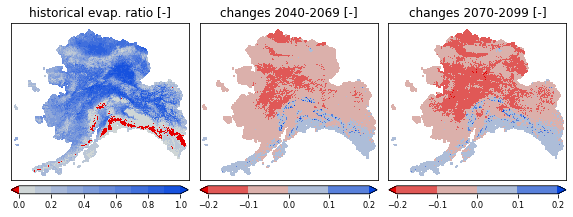

In [57]:
fig, axes = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=True, figsize=(8.125,3))
plt.subplots_adjust(left=0.040, bottom=0.0125, right=0.990, top=0.900, hspace=0.060, wspace=0.060)
histo_hydro_means.mean(dim='gcm')['EVAP_RATIO'].plot.pcolormesh(ax=axes[0], **kwargs['ER'])
rcp85_hydro_30yr_diff['middle'].mean(dim='gcm')['EVAP_RATIO'].plot.pcolormesh(ax=axes[1], **kwargs[f'change-ER'])
rcp85_hydro_30yr_diff['late'].mean(dim='gcm')['EVAP_RATIO'].plot.pcolormesh(ax=axes[2],   **kwargs[f'change-ER'])
    
axes[0].set_title('historical evap. ratio [-]', fontsize=12)
axes[1].set_title('changes 2040-2069 [-]', fontsize=12)
axes[2].set_title('changes 2070-2099 [-]', fontsize=12)

if figSave:
    plt.savefig(f'NB-AK5_Fig13_annual_mean_er_change_mid_late_rcp85.png', dpi=300)

--------
## Climate changes for individual GCMs for late 21st century are plotted below

--------------------
### Precipitation

#### rcp45

/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


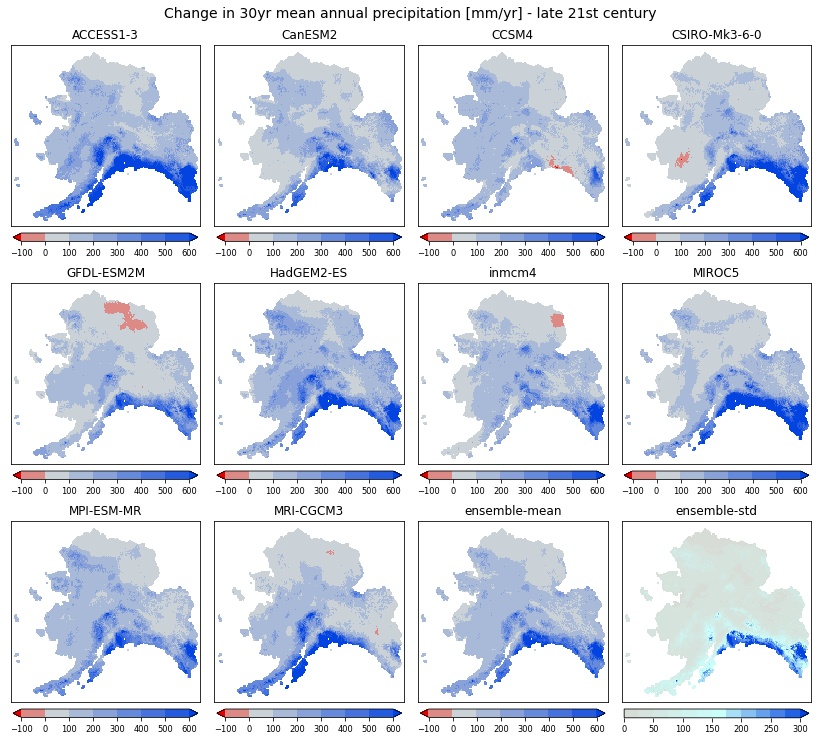

In [15]:
var="PRCP"

cm = {'mean': cmap_change_PR,
      'std' : custom_div_cmap(numcolors=256, mincol='xkcd:light grey', midcol='xkcd:light light blue', maxcol='xkcd:blue')}

style_kwargs =  {'add_labels': False, 'xticks':[], 'yticks':[], 'cbar_kwargs': dict(orientation="horizontal", shrink=0.975, pad=0.03)}
kwargs = {'mean': {'levels': 8, 'vmin':-100, 'vmax':600, 'cmap':cm['mean'], 'extend':'both', **style_kwargs},
          'std':  {'levels':13, 'vmin':0,    'vmax':300, 'cmap':cm['std'],  'extend':'max',  **style_kwargs}}

fig, axes = plt.subplots(nrows=3, ncols=4, sharex=True, sharey=True, figsize=(11.375, 10.5)) # used to be figsize=(14,11)
plt.subplots_adjust(left=0.0125, bottom=0.0125, right=0.99, top=0.935, hspace=0.075, wspace=0.075)

for ix, gcm in enumerate(gcms+['ensemble-mean','ensemble-std']):
    row = ix // 4
    col = ix % 4
    if ix < 10:
        rcp45_hydro_30yr_diff['late'][var].sel(gcm=gcm).plot.pcolormesh(ax=axes[row, col], **kwargs['mean'])
    elif ix == 10:
        rcp45_hydro_30yr_diff['late'].mean(dim='gcm')[var].plot.pcolormesh(ax=axes[row, col], **kwargs['mean'])
    elif ix == 11:
        rcp45_hydro_30yr_diff['late'].std(dim='gcm')[var].plot.pcolormesh(ax=axes[row, col], **kwargs['std'])
    axes[row, col].set_title(gcm, fontsize=12)
    
#plt.tight_layout()
fig.suptitle('Change in 30yr mean annual precipitation [mm/yr] - late 21st century', fontsize=14, y=0.985)
if figSave:
    plt.savefig(f'NB-AK5_Fig4_annual_mean_change_late_{var}_rcp45.png', dpi=300)

#### rcp85

/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


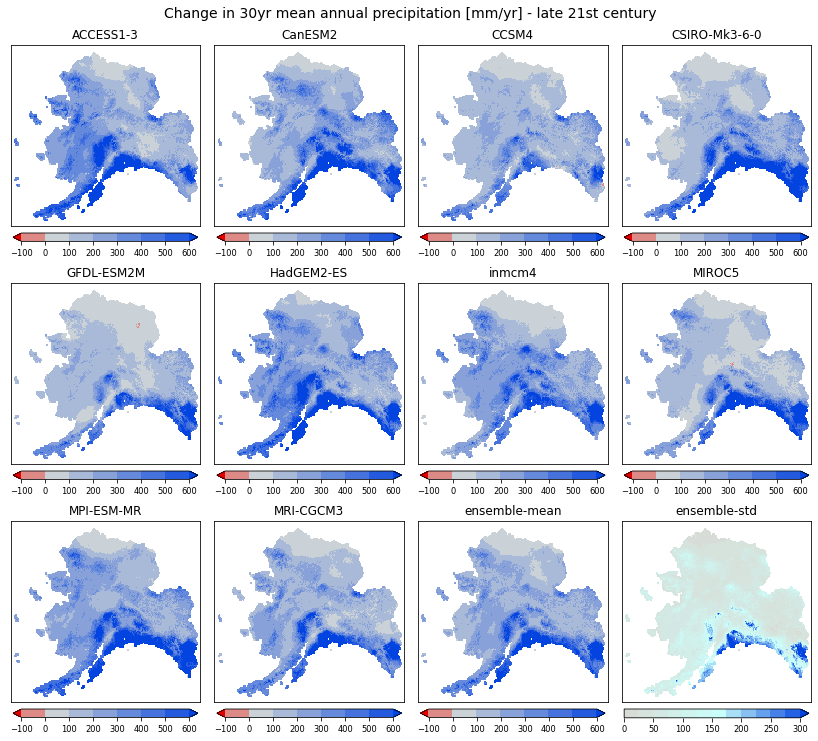

In [16]:
var="PRCP"

cm = {'mean': cmap_change_PR,
      'std' : custom_div_cmap(numcolors=256, mincol='xkcd:light grey', midcol='xkcd:light light blue', maxcol='xkcd:blue')}

style_kwargs =  {'add_labels': False, 'xticks':[], 'yticks':[], 'cbar_kwargs': dict(orientation="horizontal", shrink=0.975, pad=0.03)}
kwargs = {'mean': {'levels': 8, 'vmin':-100, 'vmax':600, 'cmap':cm['mean'], 'extend':'both', **style_kwargs},
          'std':  {'levels':13, 'vmin':0,    'vmax':300, 'cmap':cm['std'],  'extend':'max',  **style_kwargs}}

fig, axes = plt.subplots(nrows=3, ncols=4, sharex=True, sharey=True, figsize=(11.375, 10.5))  # used to be figsize=(14,11)
plt.subplots_adjust(left=0.0125, bottom=0.0125, right=0.99, top=0.935, hspace=0.075, wspace=0.075)

for ix, gcm in enumerate(gcms+['ensemble-mean','ensemble-std']):
    row = ix // 4
    col = ix % 4
    if ix < 10:
        rcp85_hydro_30yr_diff['late'][var].sel(gcm=gcm).plot.pcolormesh(ax=axes[row, col], **kwargs['mean'])
    elif ix == 10:
        rcp85_hydro_30yr_diff['late'].mean(dim='gcm')[var].plot.pcolormesh(ax=axes[row, col], **kwargs['mean'])
    elif ix == 11:
        rcp85_hydro_30yr_diff['late'].std(dim='gcm')[var].plot.pcolormesh(ax=axes[row, col], **kwargs['std'])
    axes[row, col].set_title(gcm, fontsize=12)
    
fig.suptitle('Change in 30yr mean annual precipitation [mm/yr] - late 21st century', fontsize=14, y=0.985)
if figSave:
    plt.savefig(f'NB-AK5_Fig5_annual_mean_change_late_{var}_rcp85.png', dpi=300)

--------------------
### total runoff

#### rcp45

/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


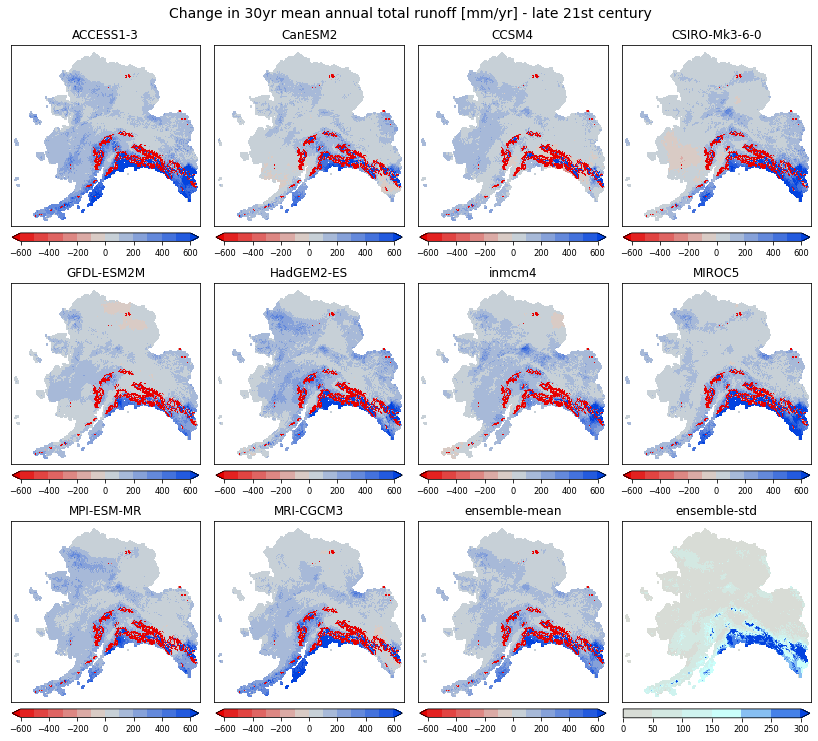

In [14]:
var="total_runoff"

cm = {'mean': custom_div_cmap(numcolors=255, mincol='xkcd:red', midcol='xkcd:light grey', maxcol='xkcd:blue'),
      'std' : custom_div_cmap(numcolors=255, mincol='xkcd:light grey', midcol='xkcd:light light blue', maxcol='xkcd:blue')}

style_kwargs =  {'add_labels': False, 'xticks':[], 'yticks':[], 'cbar_kwargs': dict(orientation="horizontal", shrink=0.985, pad=0.03)}

kwargs = {'mean': {'levels': 13, 'vmin':-600, 'vmax':600, 'cmap':cm['mean'], 'extend':'both', **style_kwargs},
          'std':  {'levels': 7, 'vmin':0,    'vmax':300, 'cmap':cm['std'],  'extend':'max',  **style_kwargs}}

fig, axes = plt.subplots(nrows=3, ncols=4, sharex=True, sharey=True, figsize=(11.375, 10.5)) # used to be figsize=(14,11)
plt.subplots_adjust(left=0.0125, bottom=0.0125, right=0.99, top=0.935, hspace=0.075, wspace=0.075)

for ix, gcm in enumerate(gcms+['ensemble-mean','ensemble-std']):
    row = ix // 4
    col = ix % 4
    if ix < 10:
        rcp45_hydro_30yr_diff['late'][var].sel(gcm=gcm).plot.pcolormesh(ax=axes[row, col], **kwargs['mean'])
    elif ix == 10:
        rcp45_hydro_30yr_diff['late'].mean(dim='gcm')[var].plot.pcolormesh(ax=axes[row, col], **kwargs['mean'])
    elif ix == 11:
        rcp45_hydro_30yr_diff['late'].std(dim='gcm')[var].plot.pcolormesh(ax=axes[row, col], **kwargs['std'])
    axes[row, col].set_title(gcm, fontsize=12)
    
#plt.tight_layout()
fig.suptitle('Change in 30yr mean annual total runoff [mm/yr] - late 21st century', fontsize=14, y=0.985)
if figSave:
    plt.savefig(f'NB-AK5_Fig7_annual_mean_change_late_{var}_rcp45.png', dpi=300)

#### rcp85

/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


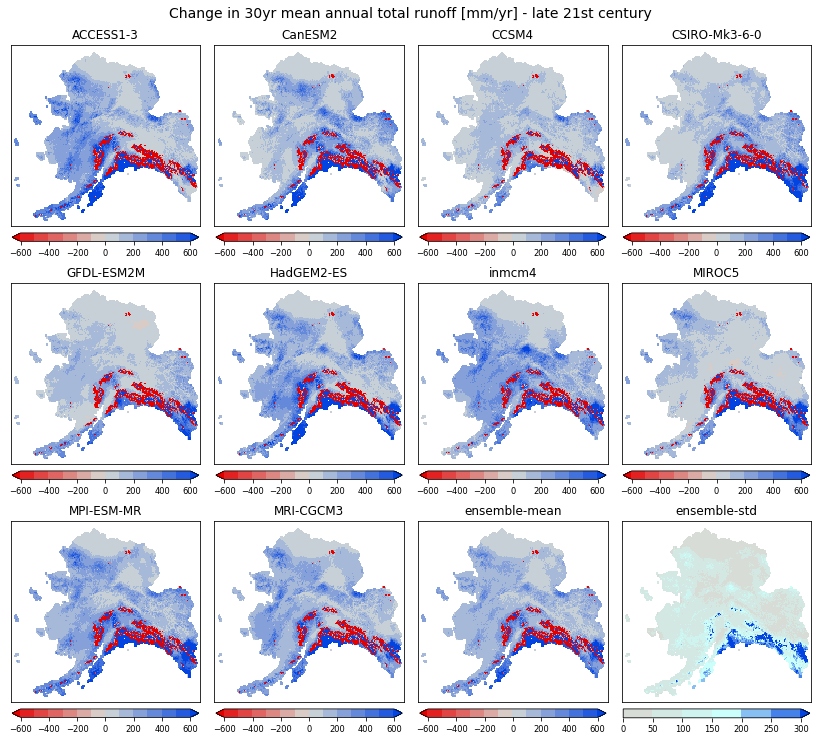

In [15]:
var="total_runoff"

cm = {'mean': custom_div_cmap(numcolors=255, mincol='xkcd:red', midcol='xkcd:light grey', maxcol='xkcd:blue'),
      'std' : custom_div_cmap(numcolors=255, mincol='xkcd:light grey', midcol='xkcd:light light blue', maxcol='xkcd:blue')}

style_kwargs =  {'add_labels': False, 'xticks':[], 'yticks':[], 'cbar_kwargs': dict(orientation="horizontal", shrink=0.985, pad=0.03)}

kwargs = {'mean': {'levels': 13, 'vmin':-600, 'vmax':600, 'cmap':cm['mean'], 'extend':'both', **style_kwargs},
          'std':  {'levels': 7, 'vmin':0,    'vmax':300, 'cmap':cm['std'],  'extend':'max',  **style_kwargs}}

fig, axes = plt.subplots(nrows=3, ncols=4, sharex=True, sharey=True, figsize=(11.375, 10.5))  # used to be figsize=(14,11)
plt.subplots_adjust(left=0.0125, bottom=0.0125, right=0.99, top=0.935, hspace=0.075, wspace=0.075)

for ix, gcm in enumerate(gcms+['ensemble-mean','ensemble-std']):
    row = ix // 4
    col = ix % 4
    if ix < 10:
        rcp85_hydro_30yr_diff['late'][var].sel(gcm=gcm).plot.pcolormesh(ax=axes[row, col], **kwargs['mean'])
    elif ix == 10:
        rcp85_hydro_30yr_diff['late'].mean(dim='gcm')[var].plot.pcolormesh(ax=axes[row, col], **kwargs['mean'])
    elif ix == 11:
        rcp85_hydro_30yr_diff['late'].std(dim='gcm')[var].plot.pcolormesh(ax=axes[row, col], **kwargs['std'])
    axes[row, col].set_title(gcm, fontsize=12)
    
fig.suptitle('Change in 30yr mean annual total runoff [mm/yr] - late 21st century', fontsize=14, y=0.985)
if figSave:
    plt.savefig(f'NB-AK5_Fig8_annual_mean_change_late_{var}_rcp85.png', dpi=300)

-------------------------
### Evapotranspiration

#### rcp45

/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


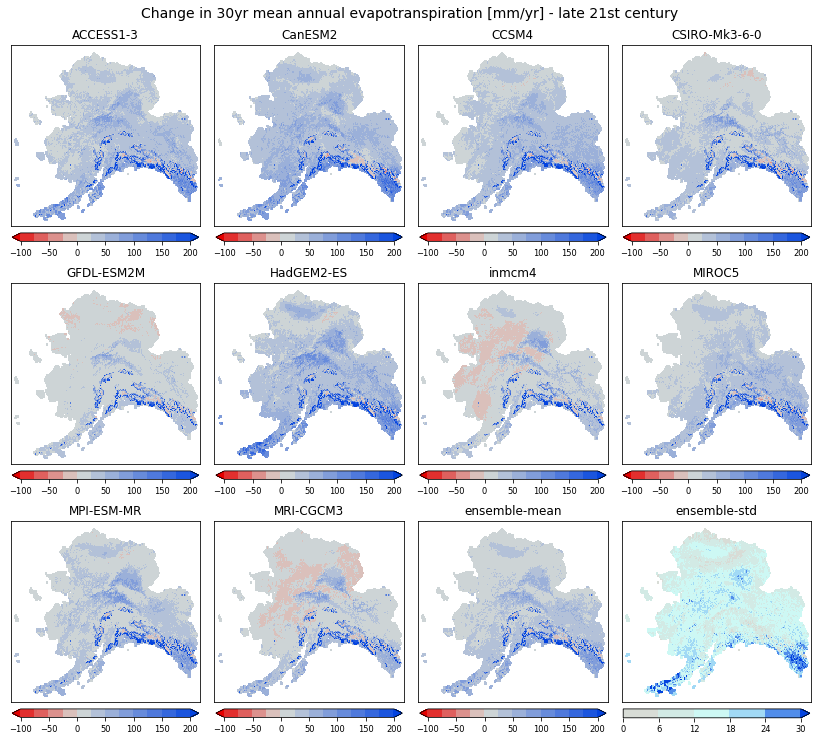

In [19]:
var="EVAP"

cm = {'mean': cmap_change_ET,
      'std' : custom_div_cmap(numcolors=255, mincol='xkcd:light grey', midcol='xkcd:light light blue', maxcol='xkcd:blue')}

style_kwargs =  {'add_labels': False, 'xticks':[], 'yticks':[], 'cbar_kwargs': dict(orientation="horizontal", shrink=0.985, pad=0.03)}

kwargs = {'mean': {'levels': 13, 'vmin':-100, 'vmax':200, 'cmap':cm['mean'], 'extend':'both', **style_kwargs},
          'std':  {'levels':  6, 'vmin':0,    'vmax': 30, 'cmap':cm['std'],  'extend':'max',  **style_kwargs}}

fig, axes = plt.subplots(nrows=3, ncols=4, sharex=True, sharey=True, figsize=(11.375, 10.5))
plt.subplots_adjust(left=0.0125, bottom=0.0125, right=0.99, top=0.935, hspace=0.075, wspace=0.075)

for ix, gcm in enumerate(gcms+['ensemble-mean','ensemble-std']):
    row = ix // 4
    col = ix % 4
    if ix < 10:
        rcp45_hydro_30yr_diff['late'][var].sel(gcm=gcm).plot.pcolormesh(ax=axes[row, col], **kwargs['mean'])
    elif ix == 10:
        rcp45_hydro_30yr_diff['late'].mean(dim='gcm')[var].plot.pcolormesh(ax=axes[row, col], **kwargs['mean'])
    elif ix == 11:
        rcp45_hydro_30yr_diff['late'].std(dim='gcm')[var].plot.pcolormesh(ax=axes[row, col], **kwargs['std'])
    axes[row, col].set_title(gcm, fontsize=12)
    
fig.suptitle('Change in 30yr mean annual evapotranspiration [mm/yr] - late 21st century', fontsize=14, y=0.985)
if figSave:
    plt.savefig(f'NB-AK5_Fig10_annual_mean_change_late_{var}_rcp45.png', dpi=300)

#### rcp85

/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


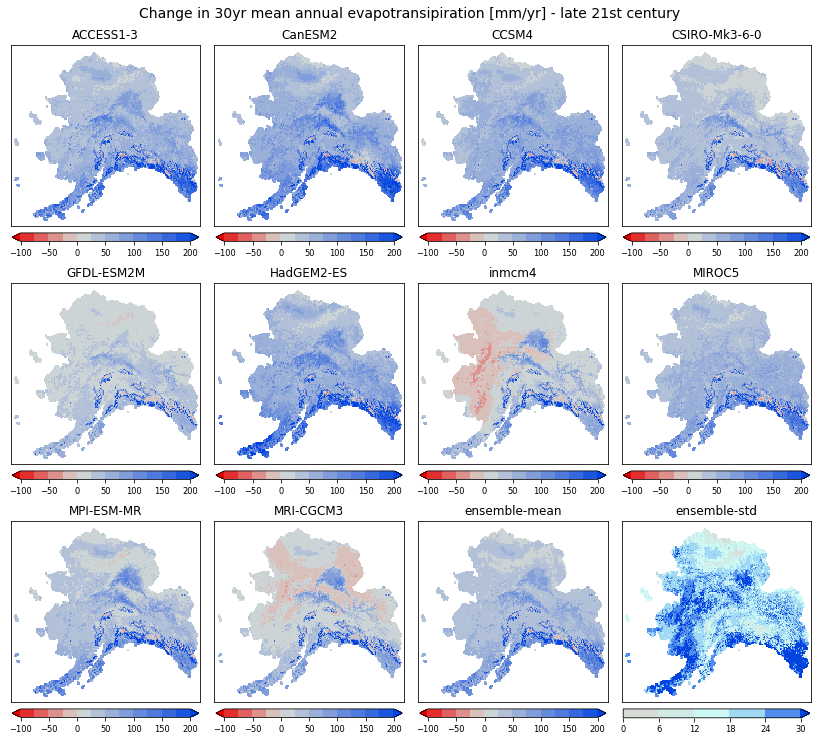

In [20]:
var="EVAP"

cm = {'mean': cmap_change_ET,
      'std' : custom_div_cmap(numcolors=255, mincol='xkcd:light grey', midcol='xkcd:light light blue', maxcol='xkcd:blue')}

style_kwargs =  {'add_labels': False, 'xticks':[], 'yticks':[], 'cbar_kwargs': dict(orientation="horizontal", shrink=0.985, pad=0.03)}

#kwargs = {'mean': {'norm':norm,  'cmap':cm['mean'], 'extend':'both', **style_kwargs},
#          'std':  {'vmin':0,   'vmax':30, 'cmap':cm['std'], 'extend':'max', **style_kwargs}}

kwargs = {'mean': {'levels': 13, 'vmin':-100, 'vmax':200, 'cmap':cm['mean'], 'extend':'both', **style_kwargs},
          'std':  {'levels': 6, 'vmin':0,    'vmax':30, 'cmap':cm['std'],  'extend':'max',  **style_kwargs}}

fig, axes = plt.subplots(nrows=3, ncols=4, sharex=True, sharey=True, figsize=(11.375, 10.5))
plt.subplots_adjust(left=0.0125, bottom=0.0125, right=0.99, top=0.935, hspace=0.075, wspace=0.075)

for ix, gcm in enumerate(gcms+['ensemble-mean','ensemble-std']):
    row = ix // 4
    col = ix % 4
    if ix < 10:
        rcp85_hydro_30yr_diff['late'][var].sel(gcm=gcm).plot.pcolormesh(ax=axes[row, col], **kwargs['mean'])
    elif ix == 10:
        rcp85_hydro_30yr_diff['late'].mean(dim='gcm')[var].plot.pcolormesh(ax=axes[row, col], **kwargs['mean'])
    elif ix == 11:
        rcp85_hydro_30yr_diff['late'].std(dim='gcm')[var].plot.pcolormesh(ax=axes[row, col], **kwargs['std'])
    axes[row, col].set_title(gcm, fontsize=12)
    
fig.suptitle('Change in 30yr mean annual evapotransipiration [mm/yr] - late 21st century', fontsize=14, y=0.985)
if figSave:
    plt.savefig(f'NB-AK5_Fig11_annual_mean_change_late_{var}_rcp85.png', dpi=300)

## Cofficient of variation of future changes for each variables

#### RCP8.5

/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x

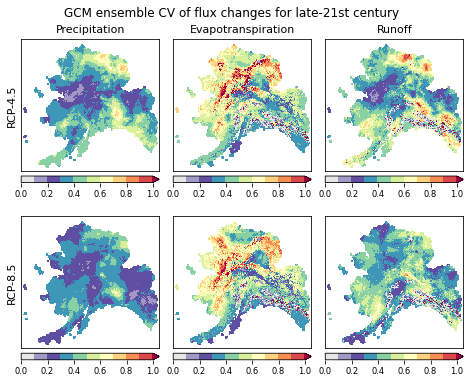

In [17]:
# uncertainty
cm = {'cv': cmap}

style_kwargs =  {'add_labels': False, 'xticks':[], 'yticks':[], 'cbar_kwargs': dict(orientation="horizontal", pad=0.03)}
kwargs = {'cv': {'levels': 11, 'vmin':0, 'vmax':1.0, 'cmap':cm['cv'], 'extend':'max', **style_kwargs}}

var_title = {'PRCP':'Precipitation', 'EVAP':'Evapotranspiration', 'total_runoff':'Runoff'}

fig, axes = plt.subplots(nrows=2, ncols=3, sharex=True, sharey=True, figsize=(6.5, 5.25)) # used to be figsize=(14,11)
plt.subplots_adjust(left=0.05, bottom=0.005, right=0.995, top=0.900, hspace=0.1, wspace=0.1)

mean ={}; std={}; cv={}
for ix, var in enumerate(hydro_flux_vars):
    
    mean[var] = {45: rcp45_hydro_30yr_diff['late'].mean(dim='gcm')[var],
                 85: rcp85_hydro_30yr_diff['late'].mean(dim='gcm')[var]}
    
    std[var]  = {45: rcp45_hydro_30yr_diff['late'].std(dim='gcm')[var],
                 85: rcp85_hydro_30yr_diff['late'].std(dim='gcm')[var]}
    
    cv[var]   = {45: std[var][45]/abs(mean[var][45]),
                 85: std[var][85]/abs(mean[var][85])}
    
    cv[var][45].plot.pcolormesh(ax=axes[0,ix], **kwargs['cv'])
    cv[var][85].plot.pcolormesh(ax=axes[1,ix], **kwargs['cv'])
    axes[0,0].set_ylabel('RCP-4.5', fontsize=11)
    axes[1,0].set_ylabel('RCP-8.5', fontsize=11)
    axes[0,ix].set_title('%s'%var_title[var], fontsize=11)
    
fig.suptitle('GCM ensemble CV of flux changes for late-21st century', fontsize=12, y=0.985)
if figSave:
    plt.savefig(f'NB-AK5_Fig12_cv_change_rcp85.png', dpi=300)

In [18]:
class AutoVivification(dict):
    """Implementation of perl's autovivification feature to initialize structure."""
    def __getitem__(self, item):
        try:
            return dict.__getitem__(self, item)
        except KeyError:
            value = self[item] = type(self)()
        return value

In [19]:
# Get std and cv stats over the domain
quantile_list = [0.02,0.1,0.2,0.5,0.8,0.9,0.98]
mean_list = AutoVivification() 
std_list  = AutoVivification()  
cv_list   = AutoVivification() 

for jx, rcp in enumerate([45,85]):
    for ix, var in enumerate(hydro_flux_vars):
    
        #mask out grid boxes with small mean values (< median)
        med = np.nanquantile(mean[var][rcp].values,0.5)
        masked_mean = mean[var][rcp].where(mean[var][rcp]>med)
        masked_std  = std[var][rcp].where(mean[var][rcp]>med)
        masked_cv   = cv[var][rcp].where(mean[var][rcp]>med)
    
        mean_list[var][rcp] = np.nanquantile(mean[var][rcp].values, quantile_list).tolist()
        std_list[var][rcp]  = np.nanquantile(std[var][rcp].values, quantile_list).tolist()
        cv_list[var][rcp]   = np.nanquantile(cv[var][rcp].values,  quantile_list).tolist()

/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/glade

In [38]:
for rcp in [45,85]:
    print(f'rcp-{rcp}')
    for ix, var in enumerate(hydro_flux_vars):
        print(f'{var}')
        print('quantile:', *quantile_list)
        print('mean    :', *mean_list[var][rcp])
        print('std.dev :', *std_list[var][rcp])
        print('C.V.    :', *cv_list[var][rcp])
        print('\n')

rcp-45
PRCP
quantile: 0.02 0.1 0.2 0.5 0.8 0.9 0.98
mean    : 41.106283569335936 69.71145553588867 94.79112701416015 131.89614868164062 220.94472045898442 345.3587615966797 615.069693603516
std.dev : 20.017437896728513 26.074658203124997 31.432712936401366 45.22965431213379 89.44454345703127 156.69229736328126 286.5231622314454
C.V.    : 0.19621692299842836 0.25670796632766724 0.29441534280776976 0.3834630250930786 0.4779322981834412 0.5374050617218018 0.6466565680503845


EVAP
quantile: 0.02 0.1 0.2 0.5 0.8 0.9 0.98
mean    : 6.133149938583374 13.754855251312257 17.196504974365233 25.960052490234375 47.91676406860352 68.74505004882813 160.87912506103524
std.dev : 5.5870804023742675 8.812354183197021 10.579970932006836 13.583494186401367 17.486996459960938 20.705767822265628 28.493936004638684
C.V.    : 0.07387026280164719 0.2806329905986786 0.36769063472747804 0.5209553241729736 0.6793231010437012 0.7924588084220886 1.101135134696957


total_runoff
quantile: 0.02 0.1 0.2 0.5 0.8 0.9 0

## domain-wide mean change and spread among GCM

In [46]:
domain_wide_mean = {}
domain_wide_std  = {}
for ix, var in enumerate(hydro_flux_vars):
    
    domain_wide_mean[var] = {45: rcp45_hydro_30yr_diff['late'][var].median(dim=['x','y']).mean(dim='gcm').values,
                             85: rcp85_hydro_30yr_diff['late'][var].median(dim=['x','y']).mean(dim='gcm').values}
    
    domain_wide_std[var] = {45: rcp45_hydro_30yr_diff['late'][var].median(dim=['x','y']).std(dim='gcm').values,
                            85: rcp85_hydro_30yr_diff['late'][var].median(dim=['x','y']).std(dim='gcm').values}


In [47]:
for rcp in [45,85]:
    print(f'rcp-{rcp}')
    for ix, var in enumerate(hydro_flux_vars):
        print(f'{var}')
        print('mean    : ', domain_wide_mean[var][rcp])
        print('std.dev : ', domain_wide_std[var][rcp])
        print('\n')

rcp-45
PRCP
mean    :  130.09529
std.dev :  24.722858


EVAP
mean    :  26.449047
std.dev :  12.033148


total_runoff
mean    :  92.631714
std.dev :  19.314972


rcp-85
PRCP
mean    :  206.70532
std.dev :  43.794884


EVAP
mean    :  42.80005
std.dev :  20.1951


total_runoff
mean    :  149.02432
std.dev :  44.31658


